<a href="https://colab.research.google.com/github/Allexxandr/data-analytics-project-100/blob/main/charts_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
import os
import subprocess

In [2]:
!pip install dotenv

In [3]:
from dotenv import load_dotenv

In [ ]:
url_visit = 'https://data-charts-api.hexlet.app/visits'
params = {
    'begin': '2023-03-01',
    'end': '2023-09-01'
}

# Чтение данных
resp1 = requests.get(url_visit, params=params)
visit = pd.DataFrame(resp1.json())

# Приводим дату к нужному формату
visit = visit.sort_values(by='datetime')
visit['datetime'] = pd.to_datetime(visit['datetime'])
visit['datetime'] = visit['datetime'].dt.strftime('%Y-%m-%d')
visit = visit.rename(columns={'datetime': 'date'})

visit.head()

,visit_id,platform,user_agent,date
1845,25c1dcbb-cb2d-41dc-88c0-8f5dd8d18483,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01
1560,b09b2b11-0d64-46a2-954a-d8bcd54b207f,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
272,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
81,65f98235-9667-460c-964e-5604b75b48a1,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
607,9b298132-4992-4dff-9d5b-b8741d3b7870,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,2023-03-01


In [4]:
subprocess.run(['git', 'clone', 'https://github.com/Allexxandr/data-analytics-project-100'])

CompletedProcess(args=['git', 'clone', 'https://github.com/Allexxandr/data-analytics-project-100'], returncode=0)

In [5]:
os.chdir('data-analytics-project-100')

In [6]:
load_dotenv()

True

In [7]:
print(os.getcwd())


/content/data-analytics-project-100


In [8]:
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

if None in [DATE_BEGIN, DATE_END, API_URL]:
    raise ValueError("Required environment variables not set")

In [9]:
os.environ['DATE_BEGIN']

'2023-03-01'

In [10]:
url_visit = f'{API_URL}/visits'
params = {
    'begin': DATE_BEGIN,
    'end': DATE_END
}

resp1 = requests.get(url_visit, params=params)
visit = pd.DataFrame(resp1.json())

visit = visit.sort_values(by='datetime')
visit['datetime'] = pd.to_datetime(visit['datetime'])
visit['datetime'] = visit['datetime'].dt.strftime('%Y-%m-%d')
visit = visit.rename(columns={'datetime': 'date'})

visit.head()

,visit_id,platform,user_agent,date
1845,25c1dcbb-cb2d-41dc-88c0-8f5dd8d18483,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01
1560,b09b2b11-0d64-46a2-954a-d8bcd54b207f,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
272,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
81,65f98235-9667-460c-964e-5604b75b48a1,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
607,9b298132-4992-4dff-9d5b-b8741d3b7870,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,2023-03-01


In [11]:
url_reg = f'{API_URL}/registrations'
resp2 = requests.get(url_reg, params=params)
reg = pd.DataFrame(resp2.json())

reg = reg.sort_values(by='datetime')
reg['datetime'] = pd.to_datetime(reg['datetime'])
reg['datetime'] = reg['datetime'].dt.strftime('%Y-%m-%d')
reg = reg.rename(columns={'datetime': 'date'})

reg.head()

,date,user_id,email,platform,registration_type
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
28,2023-03-01,b7ec78b7-fdf6-443c-bba6-01e719c26efe,smithrachel@example.net,android,google
22,2023-03-01,2aeb1afe-7641-416f-a21b-d747dbe8d754,kendra89@example.com,android,google
20,2023-03-01,7188b134-a628-4138-9d46-545fb99a91a7,ghernandez@example.net,android,email
55,2023-03-01,93ae2189-9f3c-47ea-ba0a-b06db9fb43ae,lisa22@example.net,android,google


In [12]:
visit.describe()

,visit_id,platform,user_agent,date
count,263459,263459,263459,263459
unique,146085,4,32,184
top,628bc81f-ced7-44cf-818b-a64c194edb44,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,236301,13623,2624


In [13]:
reg.describe()

,date,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,184,21836,20868,3,4
top,2023-03-06,a9dfe250-351e-4a01-b4af-c9b31d1f990c,ujones@example.com,android,email
freq,230,1,6,10582,8996


In [14]:
visit_filtered = visit[~visit['user_agent'].str.contains('bot')]

last_visit = (visit_filtered
              .sort_values(['visit_id', 'date'])
              .drop_duplicates(subset=['visit_id'], keep='last'))

visit_group = (last_visit
               .groupby(['date', 'platform'])
               .size()
               .reset_index(name='visits')
               .rename(columns={'date': 'date_group'}))

reg_group = (reg
             .groupby(['date', 'platform'])
             .agg(registrations=('user_id', 'count'))
             .reset_index()
             .rename(columns={'date': 'date_group'}))

conversion = pd.merge(visit_group, reg_group, how='outer', on=['date_group', 'platform']).fillna(0)

conversion['conversion'] = (conversion['registrations'] * 100.0 / conversion['visits']).replace(0, np.nan)

conversion.to_json('./conversion.json')

conversion.head(70)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
65,2023-03-22,web,341,30,8.797654
66,2023-03-23,android,66,55,83.333333
67,2023-03-23,ios,39,32,82.051282
68,2023-03-23,web,603,36,5.970149


In [15]:
ads_campaign = pd.read_csv('https://drive.google.com/uc?export=download&id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj')
ads_campaign = ads_campaign.sort_values(by='date')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.strftime('%Y-%m-%d')
ads_campaign = ads_campaign.rename(columns={'date': 'date_group'})

ads_cost = ads_campaign.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

ads_merge = pd.merge(conversion, ads_cost, how='outer', on='date_group')

ads_merge.head(50)

,date_group,platform,visits,registrations,conversion,utm_campaign,cost
0,2023-03-01,android,75.0,61.0,81.333333,advanced_algorithms_series,212.0
1,2023-03-01,ios,22.0,18.0,81.818182,advanced_algorithms_series,212.0
2,2023-03-01,web,279.0,8.0,2.867384,advanced_algorithms_series,212.0
3,2023-03-02,android,67.0,59.0,88.059701,advanced_algorithms_series,252.0
4,2023-03-02,ios,31.0,24.0,77.419355,advanced_algorithms_series,252.0
5,2023-03-02,web,515.0,23.0,4.466019,advanced_algorithms_series,252.0
6,2023-03-03,android,26.0,22.0,84.615385,advanced_algorithms_series,202.0
7,2023-03-03,ios,40.0,34.0,85.000000,advanced_algorithms_series,202.0
8,2023-03-03,web,617.0,51.0,8.265802,advanced_algorithms_series,202.0
9,2023-03-04,android,94.0,77.0,81.914894,advanced_algorithms_series,223.0


In [16]:
# Сначала выполняем исходные преобразования
ads_campaign = pd.read_csv('https://drive.google.com/uc?export=download&id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj')
ads_campaign = ads_campaign.sort_values(by='date')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.strftime('%Y-%m-%d')
ads_campaign = ads_campaign.rename(columns={'date': 'date_group'})

# Группируем данные по рекламным кампаниям, используя first() вместо sum()
ads_cost = ads_campaign.groupby(['date_group', 'utm_campaign'])['cost'].first().reset_index()

# Используем полное внешнее соединение для сохранения всех записей
ads_merge = pd.merge(conversion, ads_cost, how='outer', on='date_group')

# Заполняем пропуски нулями только для числовых столбцов
for col in ['visits', 'registrations', 'cost', 'conversion']:
    ads_merge[col] = ads_merge[col].fillna(0)

# Обрабатываем utm_campaign
ads_merge['utm_campaign'] = ads_merge['utm_campaign'].fillna('NULL')

# Группируем результаты
ads = ads_merge.groupby(['date_group', 'utm_campaign']).first().reset_index()  # Используем first() вместо sum()
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign', 'conversion']]

# Пересчитываем коэффициент конверсии
ads['conversion'] = (ads['registrations'] * 100.0 / ads['visits']).replace([np.inf, np.nan], 0)

# Сохраняем результат
ads.to_json('./ads.json')

ads.head(150)

,date_group,visits,registrations,cost,utm_campaign,conversion
0,2023-03-01,75.0,61.0,212.0,advanced_algorithms_series,81.333333
1,2023-03-02,67.0,59.0,252.0,advanced_algorithms_series,88.059701
2,2023-03-03,26.0,22.0,202.0,advanced_algorithms_series,84.615385
3,2023-03-04,94.0,77.0,223.0,advanced_algorithms_series,81.914894
4,2023-03-05,66.0,54.0,265.0,advanced_algorithms_series,81.818182
...,...,...,...,...,...,...
145,2023-07-24,150.0,87.0,217.0,women_in_tech_symposium,58.000000
146,2023-07-25,110.0,65.0,265.0,women_in_tech_symposium,59.090909
147,2023-07-26,71.0,42.0,113.0,women_in_tech_symposium,59.154930
148,2023-07-27,36.0,31.0,0.0,NULL,86.111111


In [17]:
os.makedirs('charts', exist_ok=True)

# Verify the directory exists
print(os.listdir())

['.git', '.env', 'ads.json', 'charts_project.ipynb', 'Presentation.pdf', '.github', 'conversion.json', 'charts', 'README.md']


In [18]:
print(os.getcwd())

/content/data-analytics-project-100


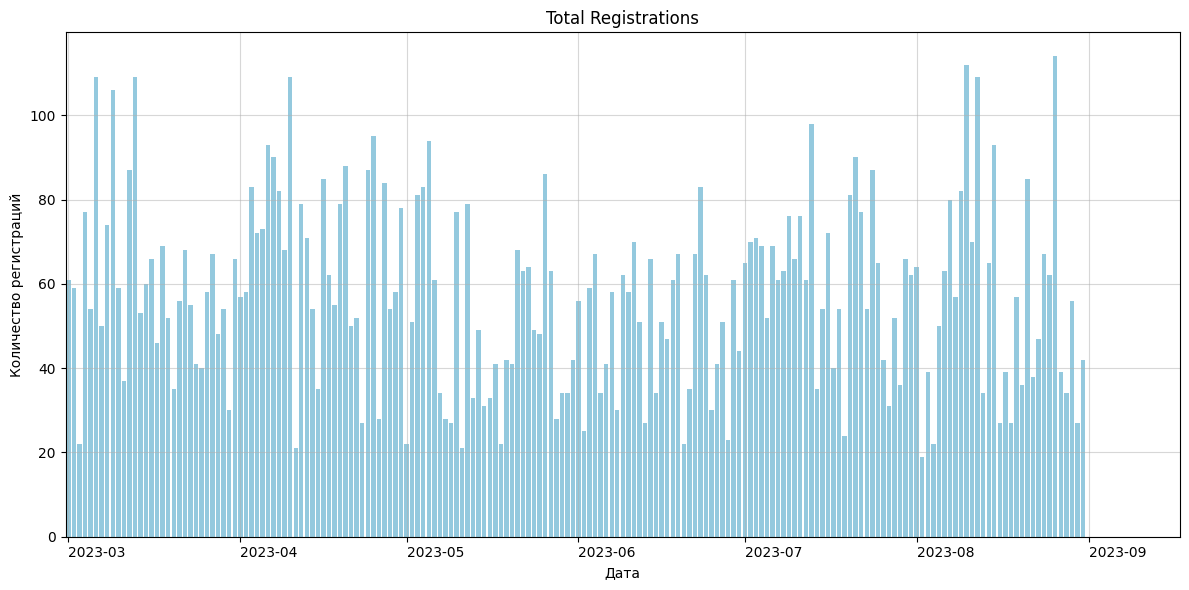

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='registrations', color='skyblue')

ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

plt.xticks(
    ticks=monthly_ticks.index,
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.title('Total Registrations')
plt.grid(alpha=0.5)
plt.tight_layout()

plt.savefig('./charts/total_registrations.png')
plt.show()

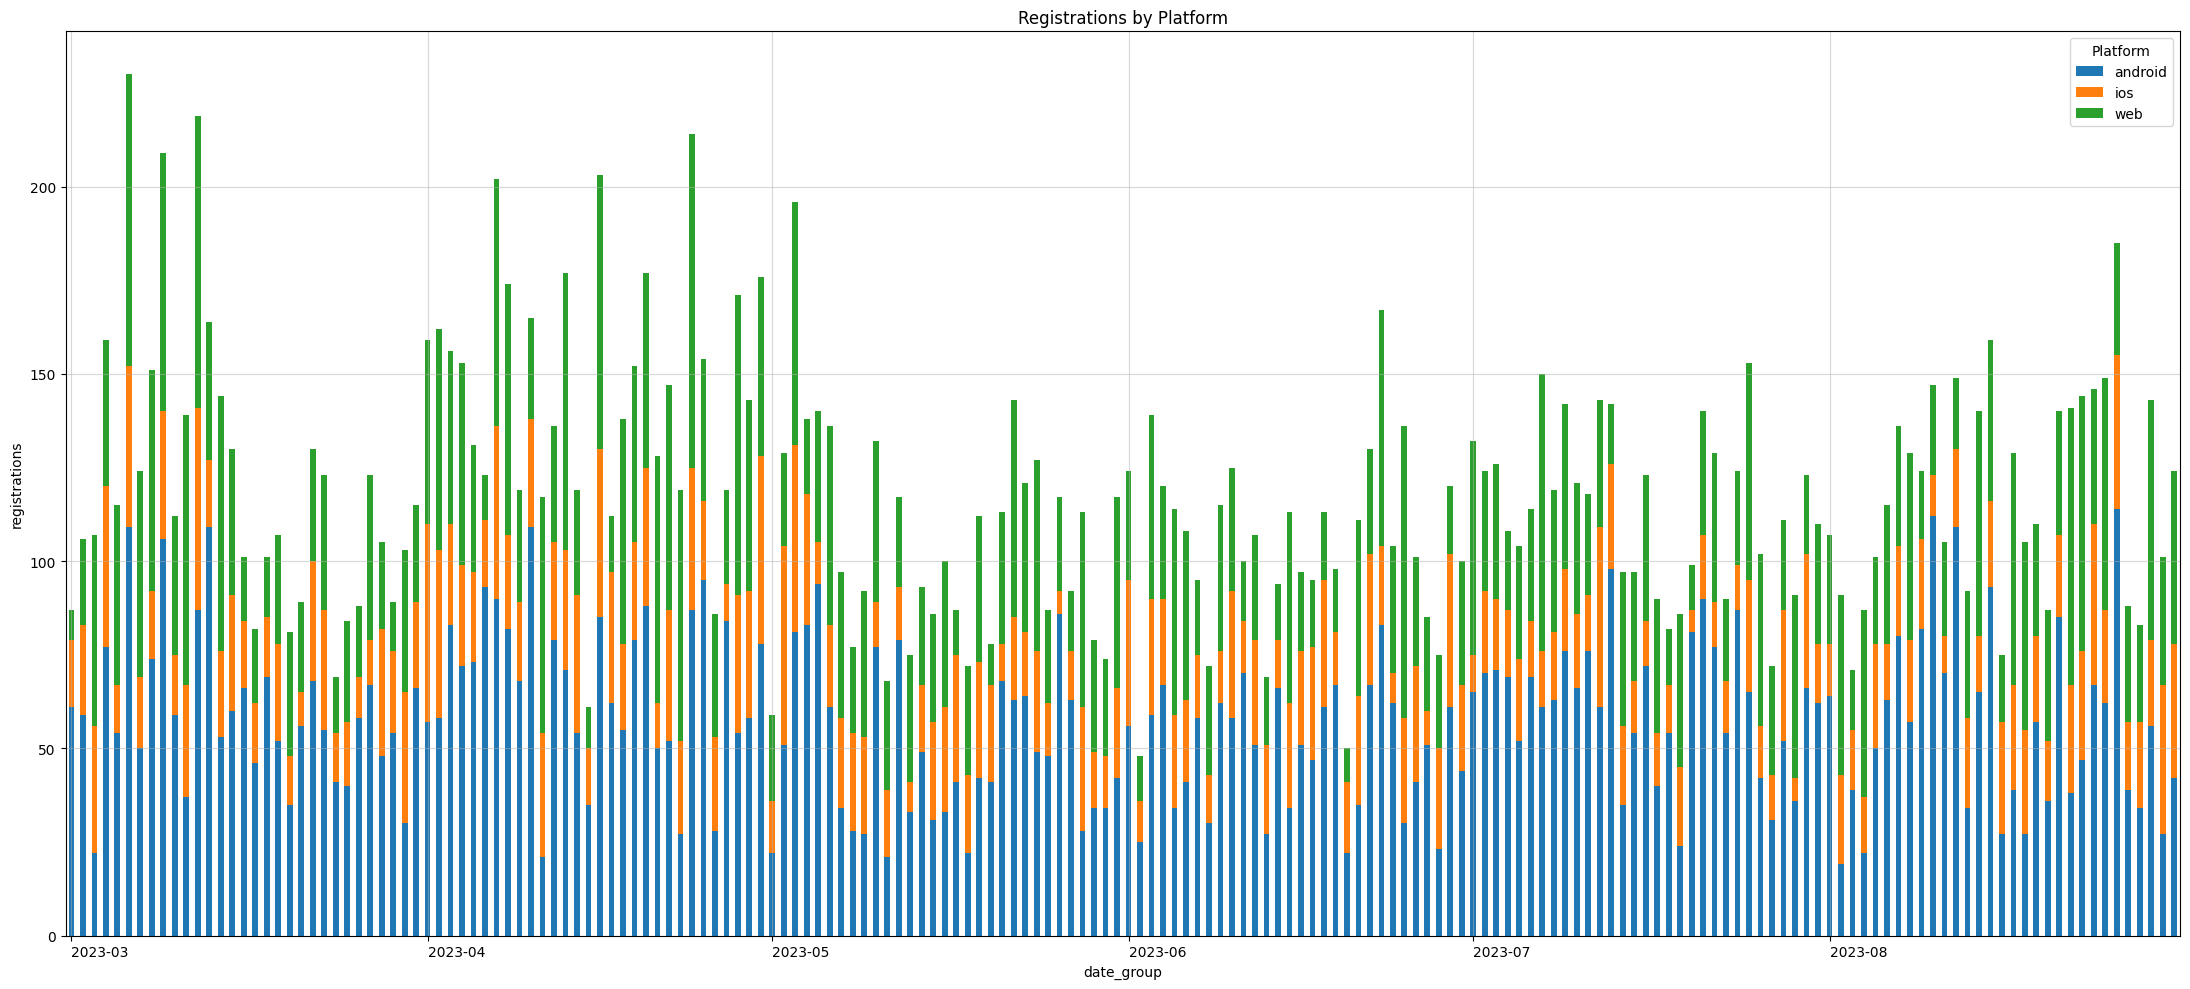

In [23]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='registrations', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Registrations by Platform')

stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(alpha=0.5)
plt.legend(title='Platform')

plt.tight_layout()

plt.savefig('./charts/visits_by_platform.png')

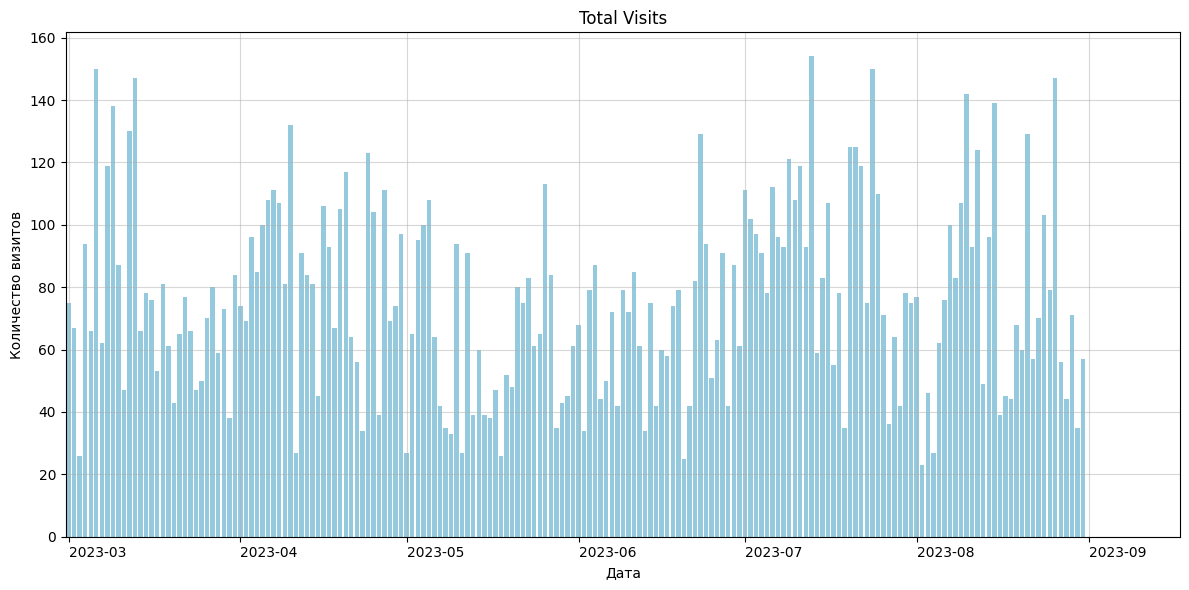

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='visits', color='skyblue')

ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

plt.xticks(
    ticks=monthly_ticks.index,
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Total Visits')
plt.grid(alpha=0.5)
plt.tight_layout()

plt.savefig('./charts/total_visits.png')
plt.show()

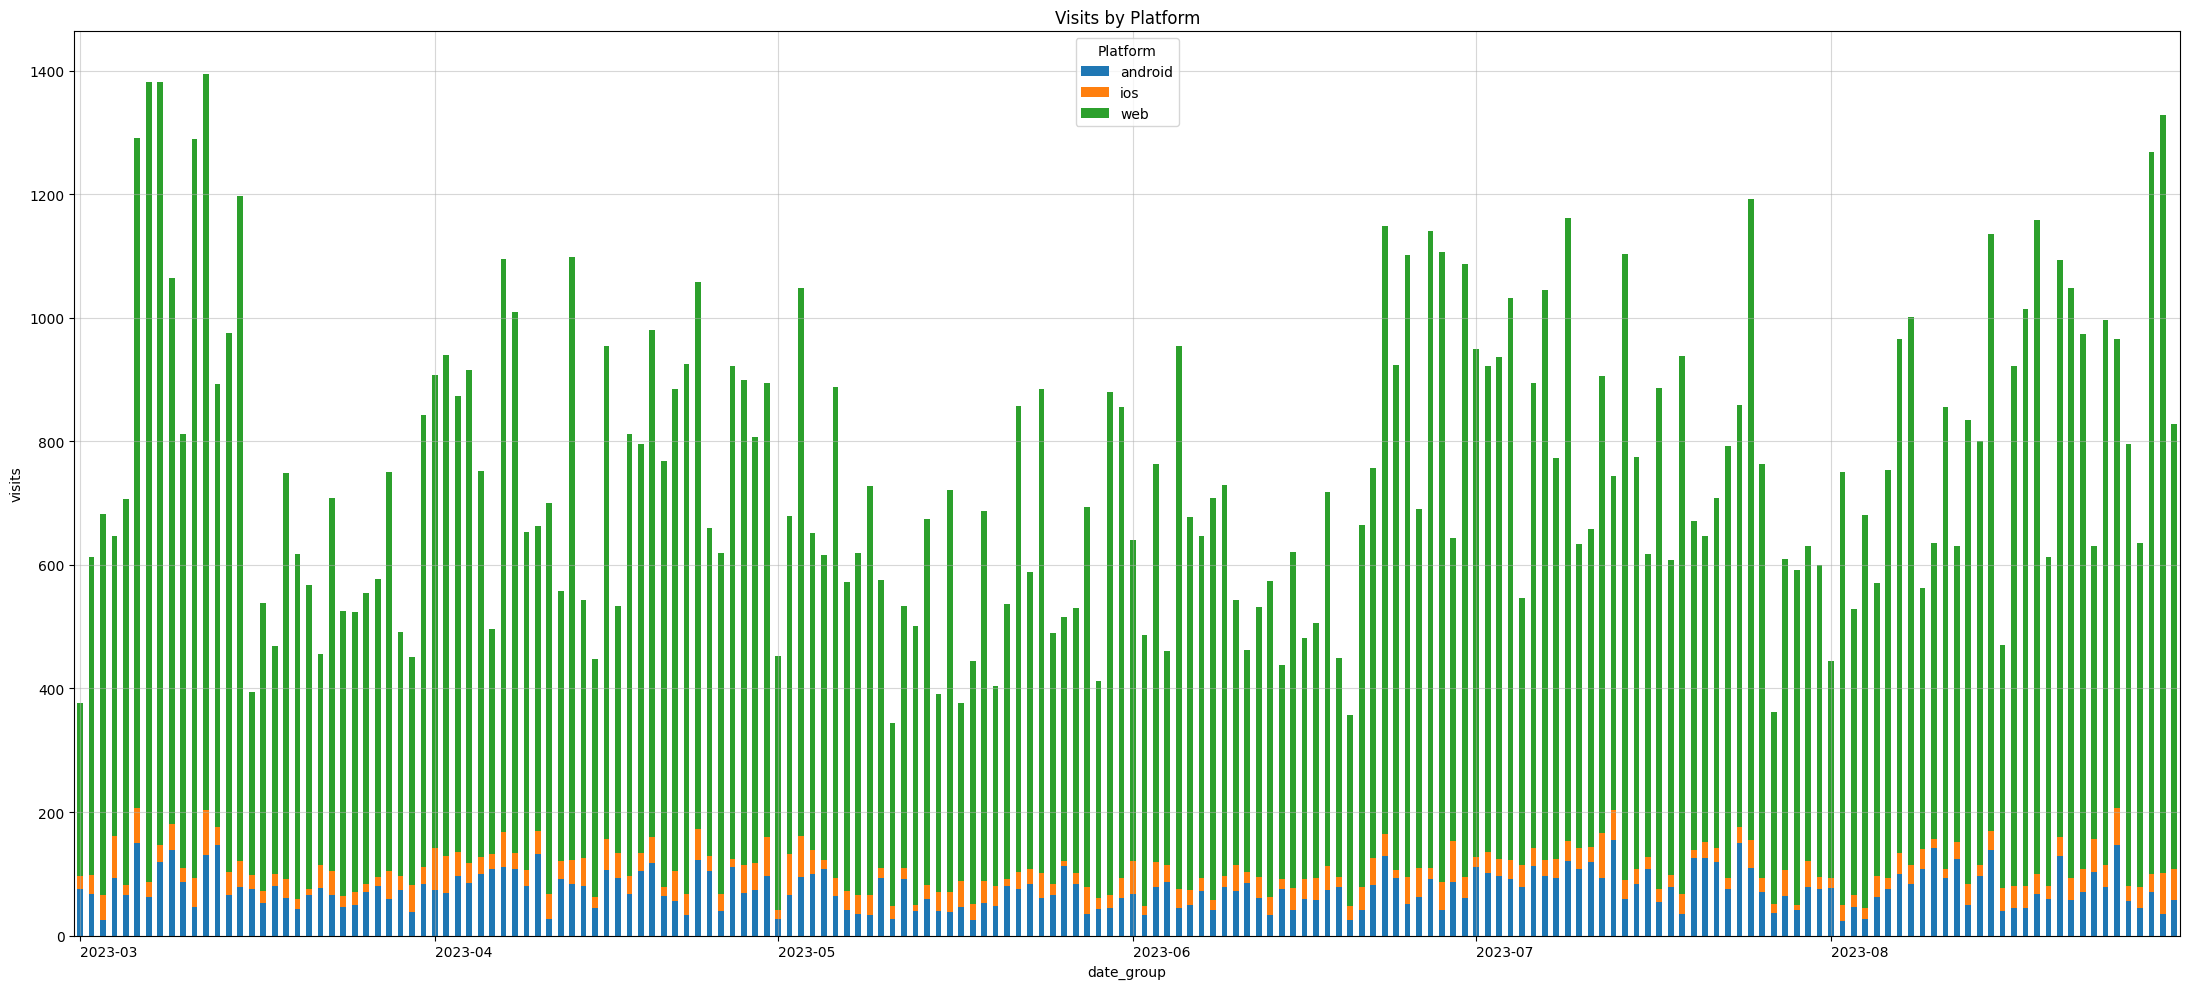

In [25]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='visits', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Visits by Platform')

stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(alpha=0.5)
plt.legend(title='Platform')

plt.tight_layout()

plt.savefig('./charts/visits_by_platform.png')

In [26]:
print("Все доступные столбцы:")
print(ads.columns.tolist())

# Проверяем типы данных
print("\nТипы данных столбцов:")
print(ads.dtypes)

# Проверяем первые несколько строк данных
print("\nПример данных:")
print(ads.head())

Все доступные столбцы:
['date_group', 'visits', 'registrations', 'cost', 'utm_campaign', 'conversion']

Типы данных столбцов:
date_group       datetime64[ns]
visits                  float64
registrations           float64
cost                    float64
utm_campaign             object
conversion              float64
dtype: object

Пример данных:
  date_group  visits  registrations   cost                utm_campaign  \
0 2023-03-01    75.0           61.0  212.0  advanced_algorithms_series   
1 2023-03-02    67.0           59.0  252.0  advanced_algorithms_series   
2 2023-03-03    26.0           22.0  202.0  advanced_algorithms_series   
3 2023-03-04    94.0           77.0  223.0  advanced_algorithms_series   
4 2023-03-05    66.0           54.0  265.0  advanced_algorithms_series   

   conversion  
0   81.333333  
1   88.059701  
2   84.615385  
3   81.914894  
4   81.818182  


In [27]:
filtered_df = ads[(ads['date_group'].astype(str) >= '2023-03-01') & (ads['date_group'].astype(str) <= '2023-09-01')]
filtered_df_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()
grouped_data = filtered_df.groupby('date_group')['visits'].sum().reset_index()
# Преобразование столбца даты в формат datetime
ads['date_group'] = pd.to_datetime(ads['date_group'])

# Извлечение года и месяца и добавление их в отдельные столбцы
ads['year_month'] = ads['date_group'].dt.to_period('M')

# Группировка данных по годам и месяцам и
# расчет средней конверсии за месяц
daily_conversion = (
    filtered_df.groupby('date_group')['conversion']
    .mean()
    .reset_index()
)

# Преобразование конверсии в проценты


print(daily_conversion)

    date_group  conversion
0   2023-03-01   81.333333
1   2023-03-02   88.059701
2   2023-03-03   84.615385
3   2023-03-04   81.914894
4   2023-03-05   81.818182
..         ...         ...
180 2023-08-28   77.272727
181 2023-08-29   78.873239
182 2023-08-30   77.142857
183 2023-08-31   73.684211
184 2023-09-01    0.000000

[185 rows x 2 columns]


In [28]:
filtered_df_conversion = conversion[(conversion['date_group'].astype(str) >= '2023-03-01') & (conversion['date_group'].astype(str) <= '2023-09-01')]

# Отфильтруем 3 датасета по каждой из платформ
android_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion']

ios_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion']

web_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion']

web_df.head()

,date_group,platform,visits,registrations,conversion
2,2023-03-01,web,279,8,2.867384
5,2023-03-02,web,515,23,4.466019
8,2023-03-03,web,617,51,8.265802
11,2023-03-04,web,485,39,8.041237
14,2023-03-05,web,625,48,7.680000


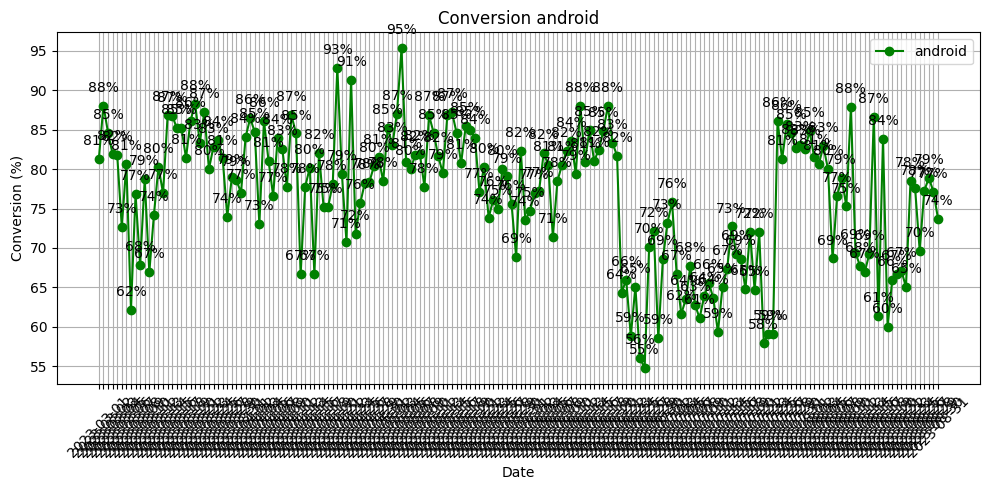

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='green', label='android')

for i, txt in enumerate(android_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conversion android')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/conversion_android.png')
plt.show()

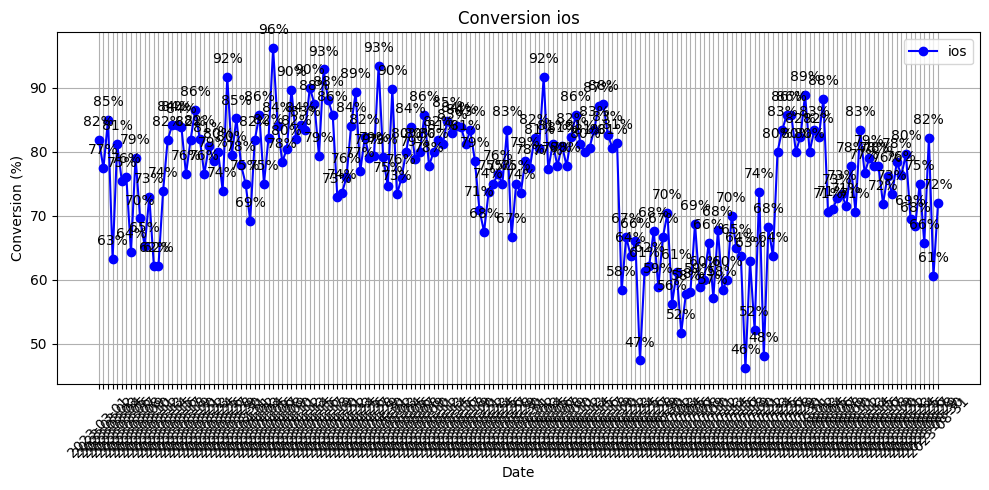

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='blue', label='ios')

for i, txt in enumerate(ios_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion ios')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/conversion_ios.png')
plt.show()

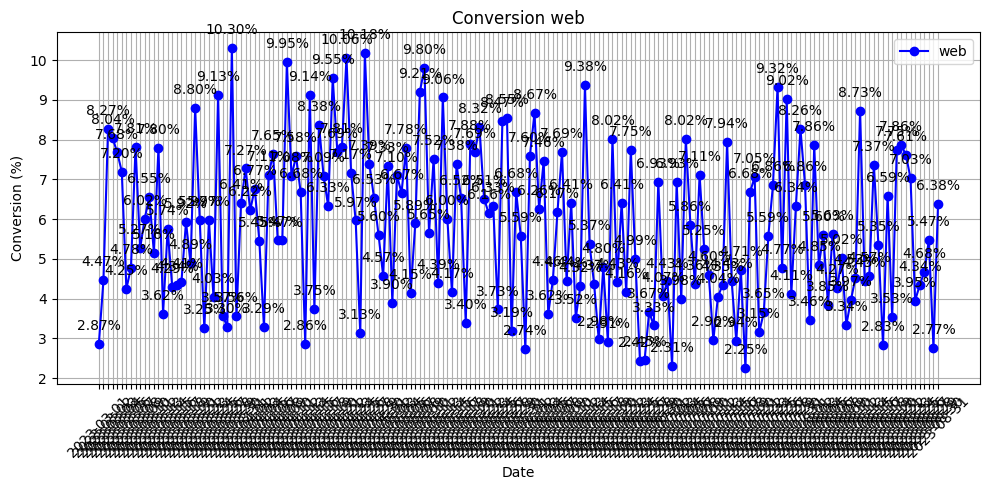

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='blue', label='web')

for i, txt in enumerate(web_df['conversion']):
    plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion web')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/conversion_web.png')
plt.show()

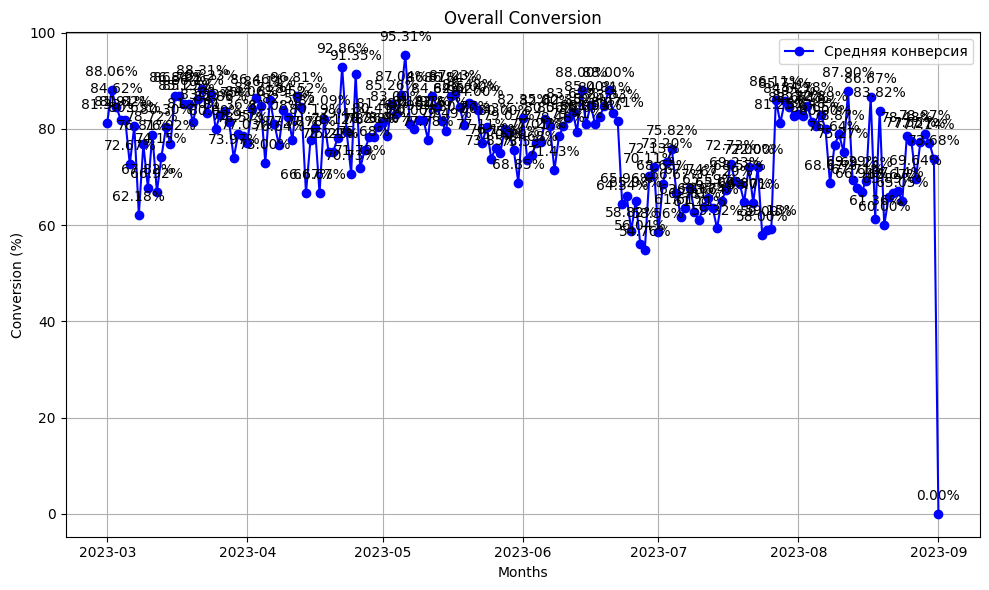

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(daily_conversion['date_group'], daily_conversion['conversion'], marker='o', linestyle='-', color='b', label='Средняя конверсия')

for i, txt in enumerate(daily_conversion['conversion']):
    plt.annotate(f'{txt:.2f}%', (daily_conversion['date_group'][i], daily_conversion['conversion'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Months')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')
plt.show()

In [32]:
ads['date_group'] = pd.to_datetime(ads['date_group'])

mask = (ads['date_group'] >= '2023-03-01') & (ads['date_group'] <= '2023-09-01')
filtered_df_costs = ads.loc[mask]

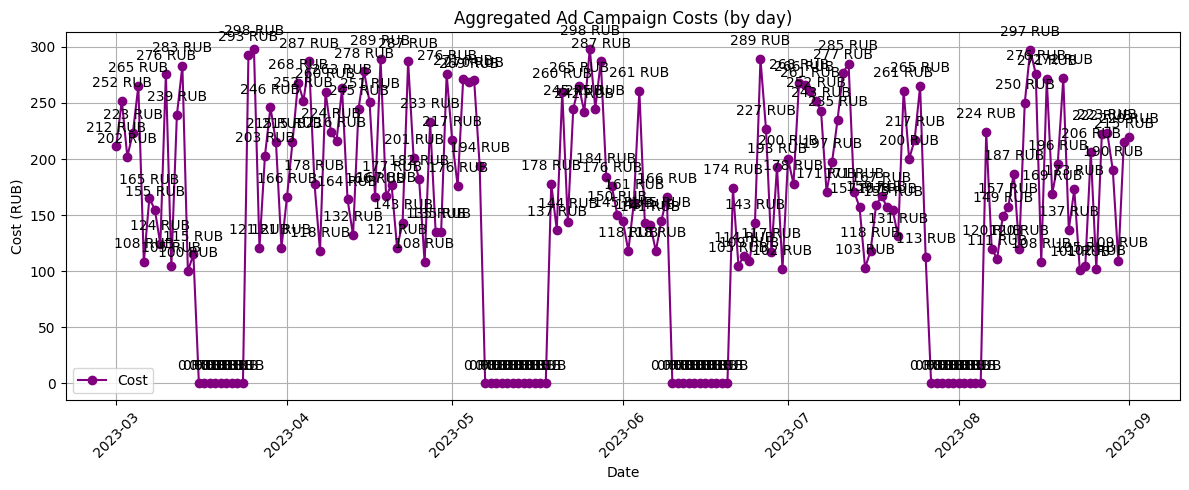

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(filtered_df_costs['date_group'], filtered_df_costs['cost'], marker='o', linestyle='-', color='purple', label='Cost')

for i, txt in enumerate(filtered_df_costs['cost']):
    plt.annotate(f'{txt:.0f} RUB', (filtered_df_costs['date_group'].iloc[i], filtered_df_costs['cost'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/aggregated_ad_campaign_costs.png')
plt.show()

NameError: name 'mdates' is not defined

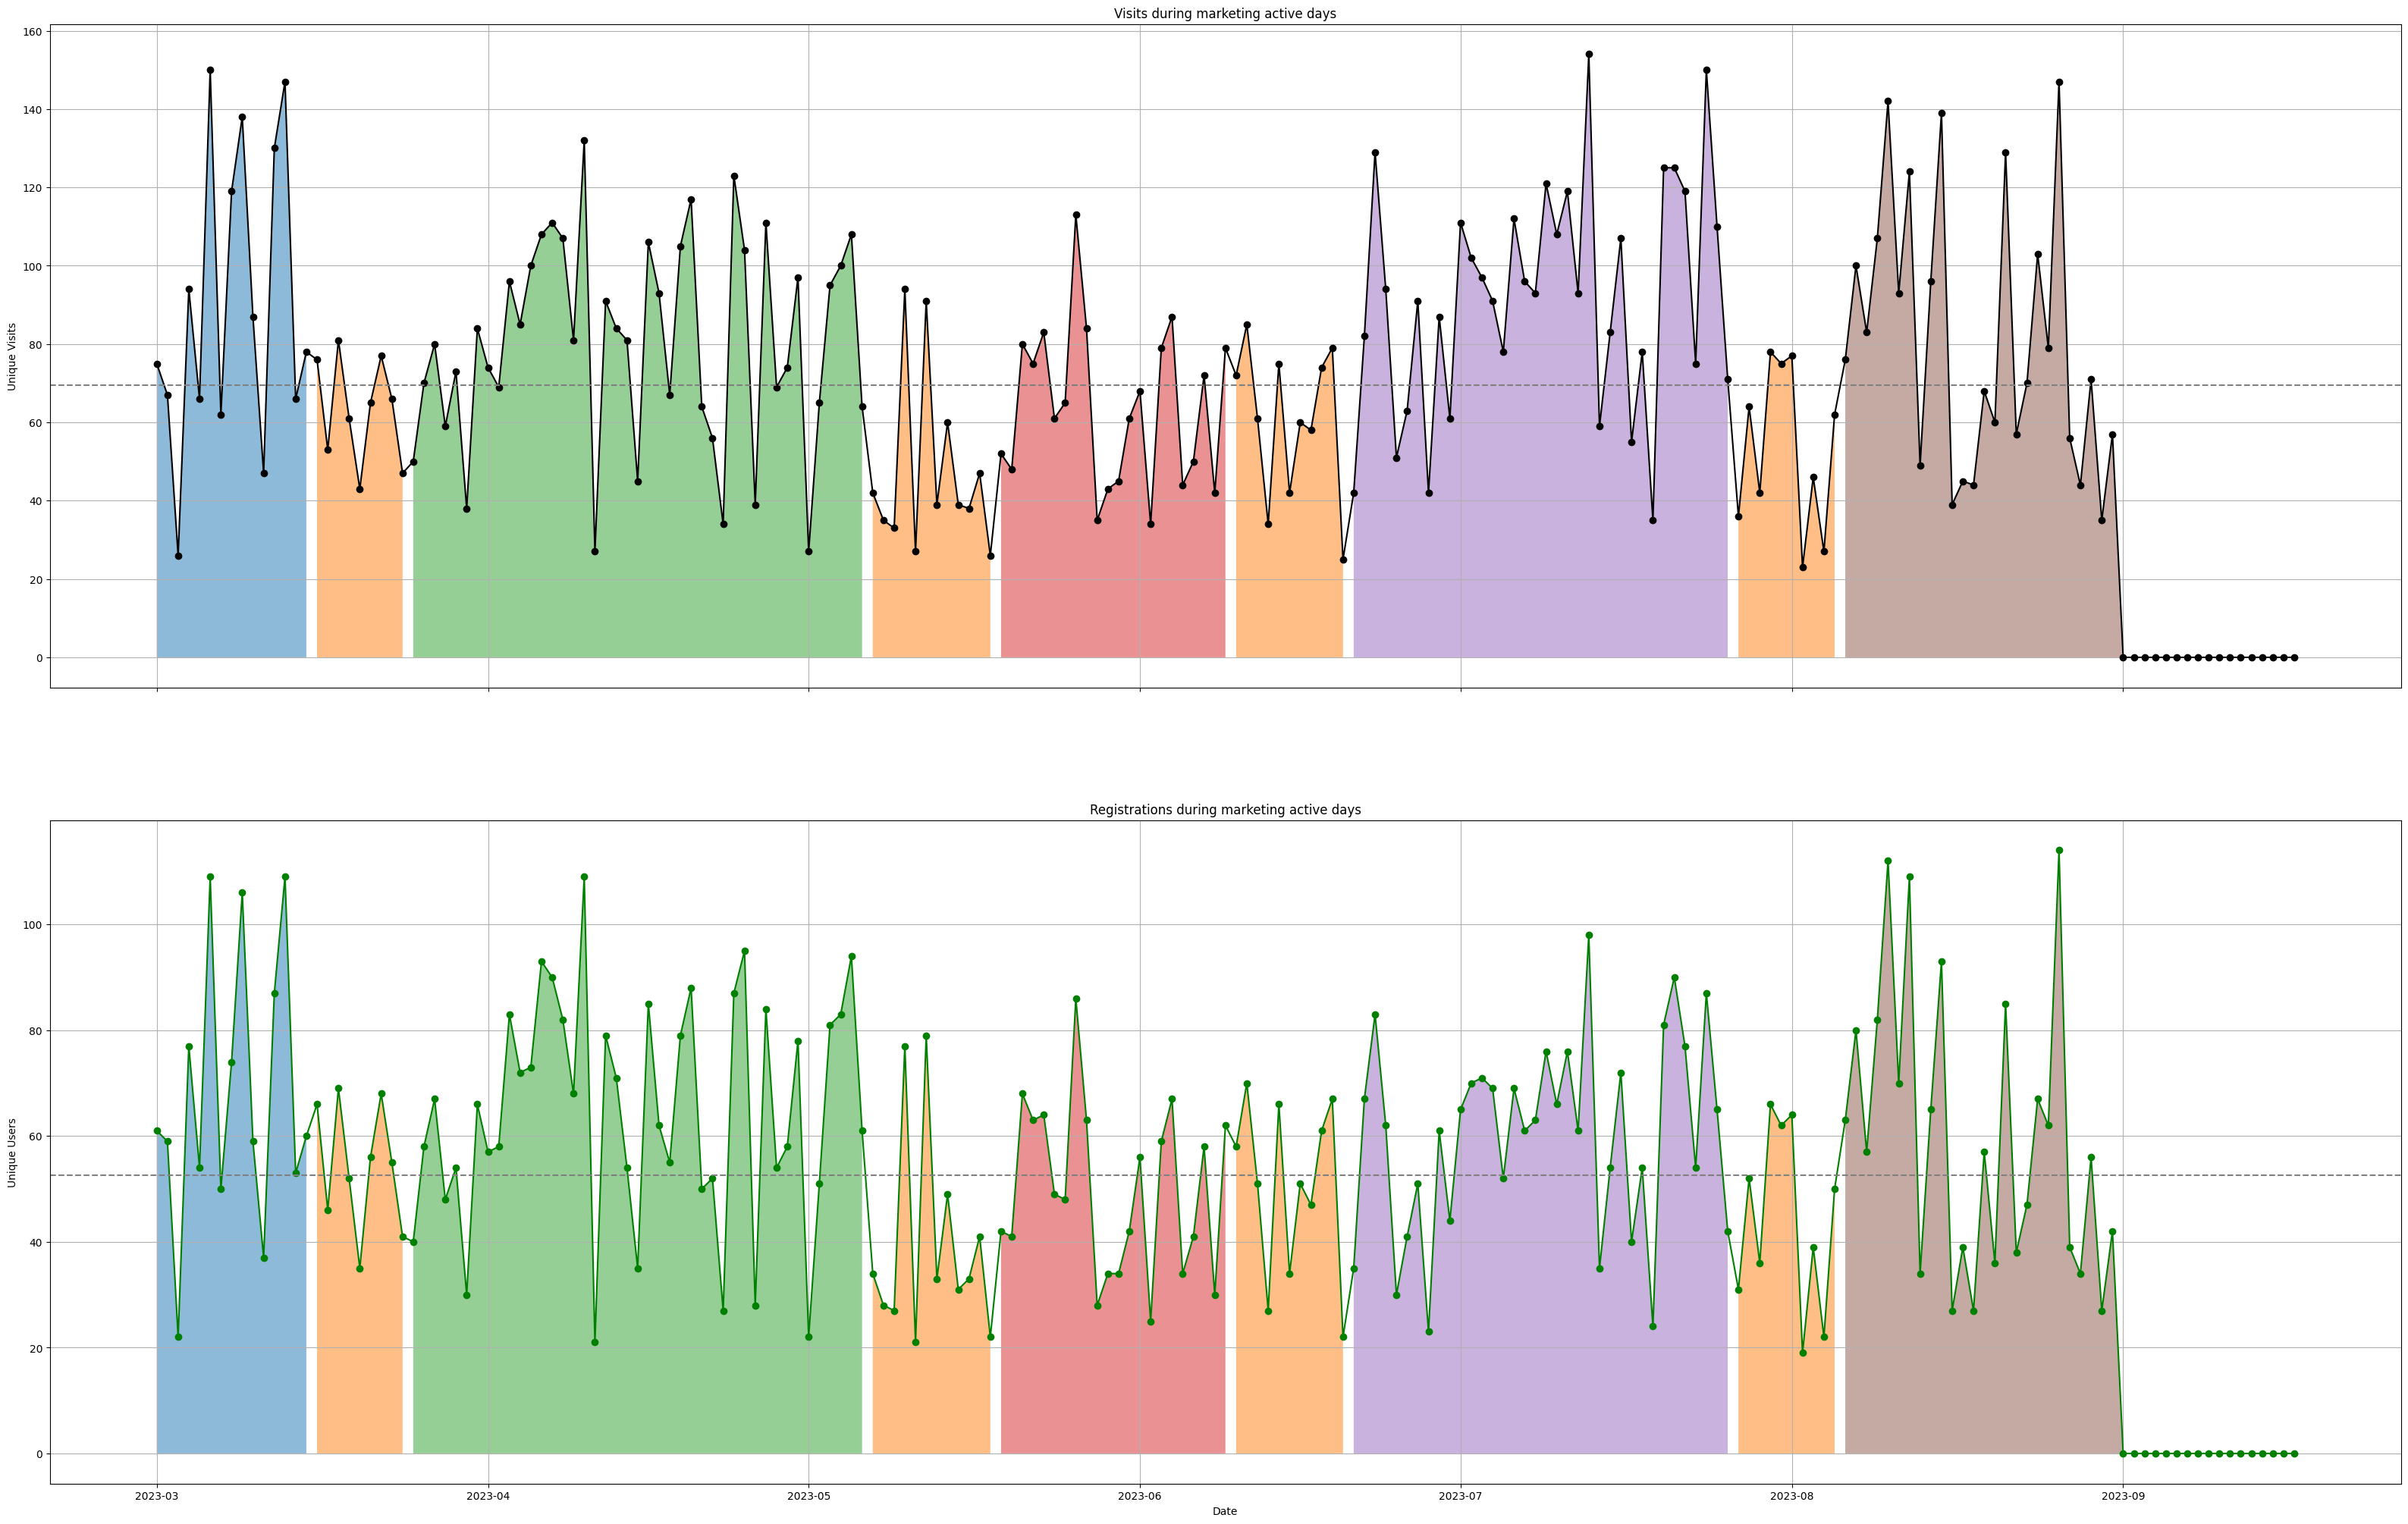

In [34]:
ads = ads[(ads['date_group'].astype(str) >= '2023-03-01') & (ads['date_group'].astype(str) <= '2023-9-01')]
unique_campaigns = ads[ads['utm_campaign'] != 0]['utm_campaign'].unique()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25), sharex=True)

handles, labels = {}, {}

# График визитов
visits_line, = ax1.plot(ads['date_group'], ads['visits'], marker='o', linestyle='-', color='black', label='Visits')
visits_mean = ax1.axhline(ads['visits'].mean(), color='gray', linestyle='--', label='Average Number of Visits')
handles.update({visits_line.get_label(): visits_line, visits_mean.get_label(): visits_mean})

for campaign in unique_campaigns:
    campaign_mask = ads['utm_campaign'] == campaign
    fill = ax1.fill_between(ads['date_group'], ads['visits'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax1.set_ylabel('Unique Visits')
ax1.set_title('Visits during marketing active days')
ax1.grid(True)

# График регистраций
registrations_line, = ax2.plot(ads['date_group'], ads['registrations'], marker='o', linestyle='-', color='green', label='Registrations')
registrations_mean = ax2.axhline(ads['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registration')
handles.update({registrations_line.get_label(): registrations_line, registrations_mean.get_label(): registrations_mean})

for campaign in unique_campaigns:
    campaign_mask = ads['utm_campaign'] == campaign
    fill = ax2.fill_between(ads['date_group'], ads['registrations'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax2.set_ylabel('Unique Users')
ax2.set_title('Registrations during marketing active days')
ax2.grid(True)

# Настройка оси X
ax2.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Расположение общей легенды
fig.legend(handles.values(), labels=[h.get_label() for h in handles.values()], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig('./charts/v_and_re_during_marketing_active_days.png')

plt.show()